#Intro to PyTorch with image classification
Compared to TensorFlow, PyTorch offers several **advantages** as a Deep Learning library. This is different from TensorFlow, in which we define the **execution graph** first, with the input and output shapes, activation functions, and order of each layer. The code is then run in a separate session. In PyTorch, you define the graph as a class of type nn.module, and feed the input data through it. The code runs as the class is called. This has several advantages as well, because the code is easier to read and intuitive, and because of its **runtime-execution model**, it is easy to debug the code as the data passes through the model.

We are going to use Fashion MNIST Dataset for this practice:
* a drop-in replacement for the MNIST handwritten digits dataset
* grayscale images of size 28x28
* more complicated features handwritten digits dataset

## Configuring Google Drive

if you need to save anything on your google drive you can config it in this way:

In [1]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate


KeyboardInterrupt: ignored

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [0]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


## Installing Pytorch on colab

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q torch==1.1.0 torchvision

# Image Classification using Pytorch

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
from keras.utils.vis_utils import *
import random;
import math;
import matplotlib.pyplot as plt
from collections import OrderedDict

### Hyperparameters

In [0]:
num_epochs = 10;
batch_size = 100;

### Dataset
* Load from drive
* Download it directly

In [0]:
class FashionMNISTDataset(Dataset):
    '''Fashion MNIST Dataset'''
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            transform (callable): Optional transform to apply to sample
        """
        
        data = pd.read_csv(csv_file);
        self.X = np.array(data.iloc[:, 1:]).reshape(-1, 1, 28, 28)#.astype(float);
        self.Y = np.array(data.iloc[:, 0]);
        
        del data;
        self.transform = transform;
        
    def __len__(self):
        return len(self.X);
    
    def __getitem__(self, idx):
        item = self.X[idx];
        label = self.Y[idx];
        
        if self.transform:
            item = self.transform(item);
        
        return (item, label);
      
train_dataset = FashionMNISTDataset(csv_file='fashionmnist/fashion-mnist_train.csv');
test_dataset = FashionMNISTDataset(csv_file='fashionmnist/fashion-mnist_test.csv')

In [0]:
train_dataset = dsets.FashionMNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = dsets.FashionMNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

### Data Loader

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

### Other heyperparameters

In [0]:
class HyperParameters:
    inputs = 28 * 28
    hidden_layer_1 = 64
    hidden_layer_2 = 32
    outputs = 10
    learning_rate = 0.005
    rows = 1

### Visualizing Data

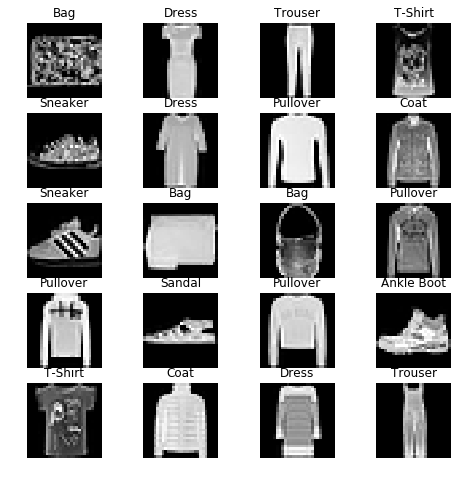

In [8]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

### Implementing the Network

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(HyperParameters.inputs, HyperParameters.hidden_layer_1),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Linear(HyperParameters.hidden_layer_1, HyperParameters.hidden_layer_2),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Linear(HyperParameters.hidden_layer_2, HyperParameters.outputs),
            nn.LogSoftmax(dim=HyperParameters.rows))
        
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out
      

#instance of the MLP
network_model = MLP();

In [19]:
pytorch_total_params = sum(p.numel() for p in network_model.parameters() if p.requires_grad)
pytorch_trainable_params = sum(p.numel() for p in network_model.parameters() if p.requires_grad)

print("Total params: ",pytorch_total_params)
print("Trainable params : ",pytorch_total_params)
print()

print(network_model)

Total params:  52650
Trainable params :  52650

MLP(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


### Loss function and optimizer

In [0]:
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(network_model.parameters(), lr=HyperParameters.learning_rate)

#criterion = nn.CrossEntropyLoss();
#optimizer = torch.optim.Adam(network_model.parameters(), lr=learning_rate);

### Training the Network

In [21]:
losses = [];
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = network_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.data);
        
        if (i+1) % 100 == 0:
            print ('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' 
                   %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data))

Epoch : 1/10, Iter : 100/600,  Loss: 2.3017
Epoch : 1/10, Iter : 200/600,  Loss: 2.2724
Epoch : 1/10, Iter : 300/600,  Loss: 2.1927
Epoch : 1/10, Iter : 400/600,  Loss: 2.1011
Epoch : 1/10, Iter : 500/600,  Loss: 2.0220
Epoch : 1/10, Iter : 600/600,  Loss: 1.9207
Epoch : 2/10, Iter : 100/600,  Loss: 1.7061
Epoch : 2/10, Iter : 200/600,  Loss: 1.6171
Epoch : 2/10, Iter : 300/600,  Loss: 1.4839
Epoch : 2/10, Iter : 400/600,  Loss: 1.3068
Epoch : 2/10, Iter : 500/600,  Loss: 1.2379
Epoch : 2/10, Iter : 600/600,  Loss: 1.2284
Epoch : 3/10, Iter : 100/600,  Loss: 1.1524
Epoch : 3/10, Iter : 200/600,  Loss: 1.0795
Epoch : 3/10, Iter : 300/600,  Loss: 0.9643
Epoch : 3/10, Iter : 400/600,  Loss: 0.9530
Epoch : 3/10, Iter : 500/600,  Loss: 0.9705
Epoch : 3/10, Iter : 600/600,  Loss: 0.8665
Epoch : 4/10, Iter : 100/600,  Loss: 0.9021
Epoch : 4/10, Iter : 200/600,  Loss: 0.8306
Epoch : 4/10, Iter : 300/600,  Loss: 0.7832
Epoch : 4/10, Iter : 400/600,  Loss: 0.8302
Epoch : 4/10, Iter : 500/600,  L

### Evaluating the network

In [22]:
network_model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = network_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 79.0000 %


### Visualizing losses

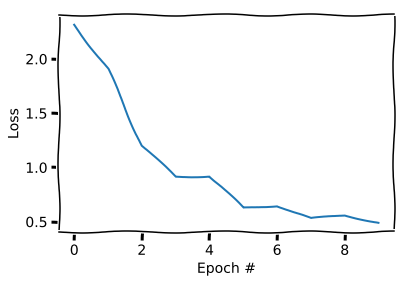

In [25]:
losses_in_epochs = losses[0::600]
plt.xkcd();
plt.xlabel('Epoch #');
plt.ylabel('Loss');
plt.plot(losses_in_epochs);
plt.show();